# 機械学習の精度を上げる（準備）

## 目次

 - この章の目的

 - クロスバリデーション

 - 特徴量の可視化

 - 機械学習の精度を上げる

 - 特徴量エンジニアリングについて

 - 特徴量エンジニアリング①：特徴量同士の相関

 - 特徴量エンジニアリング②：層別解析


## この章の目的

前の章で、とりあえず機械学習を動かす、ということをやりました。

この章では、「**精度を上げるための前準備**」が目的です。 実際には、以下の３工程をやってみます。

|やること|目的|
|-|-|
|クロスバリデーション|手元データで簡易的に精度を評価する|
|特徴量の可視化|どの変数が判別に効いているかを評価する|
|EDA|特徴量エンジニアリングのためにデータを可視化する|

## クロスバリデーション

まずは、クロスバリデーションにより、trainデータだけで精度を出せるようにします。

クロスバリデーションは「訓練用データを訓練用データと評価用のデータにわけることで、訓練用データだけで精度を出す」ことです。

イメージとしては、以下のような感じです。

### 前の章でやったこと

<img src="./assets/pic/cv.png" width="50%">

前の章では訓練用データをすべて使用して学習していました。

### 今回の章でやること

<img src="./assets/pic/cv2.png" width="50%">

今回の章では訓練用データを訓練用データと評価用のデータにわけて学習します。

実際のソースコードは以下のようになっています。

test.csv（評価用データ）はしばらく使用しないため、ソースコードから消してあります。

 - ソースコード


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

df_train = pd.read_csv("train.csv")

# 欠損値を埋める
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train["Cabin"] = df_train["Cabin"].fillna(df_train["Cabin"].mode())
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode())

# train
df_train.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
df_train["Sex"] = df_train["Sex"].replace({"male": 0, "female": 1})
df_train = pd.get_dummies(df_train)

train_y = df_train["Survived"]
train_x = df_train.drop("Survived", axis=1)

clf = xgb.XGBClassifier()
clf.fit(train_x, train_y)

accuracies = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for train_idx, test_idx in cv.split(train_x, train_y):
    trn_x = train_x.iloc[train_idx, :]
    val_x = train_x.iloc[test_idx, :]

    trn_y = train_y.iloc[train_idx]
    val_y = train_y.iloc[test_idx]

    clf = xgb.XGBClassifier()
    clf.fit(trn_x, trn_y)

    pred_y = clf.predict(val_x)
    accuracies.append(accuracy_score(val_y, pred_y))

print(np.mean(accuracies))

0.8103254769921436


/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


精度が出ること、かつ先程KaggleへSubmitした値より少し高い値が出ていることがわかると思います。

これで、精度が手元で簡単に出せるようになりました。

分割はscikit-learnライブラリの中ののStratifiedKFoldで実施することができます。

①: 変数の宣言（分割のカスタマイズはここでやる）

②: 実際の分割

と2ステップが必要です。

 - ソースコード（入力不要）

```:python
from sklearn.model_selection import StratifiedKFold

# ...

# ① 変数の宣言
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# ② 実際の分割
for train_idx, test_idx in cv.split(train_x, train_y):
    trn_x = train_x.iloc[train_idx, :]
    val_x = train_x.iloc[test_idx, :]

    trn_y = train_y.iloc[train_idx]
    val_y = train_y.iloc[test_idx]
    # ...
```

注意することとしては、分割のための変数が数字であるため`iloc`が必要であること、

`random_state` を固定しないと分割が変わり、結果が変わってしまうため、`random_state`はどの値でもよいので同じ値を使用することです。

## 特徴量の可視化

次に、特徴量の重要度を出してみます。

特徴量の重要度とは、「予測の時に、どの列の重要度が高いか？」であり、

値は`clf.feature_importances_` で出すことができます。

 - ソースコード


/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8103254769921436


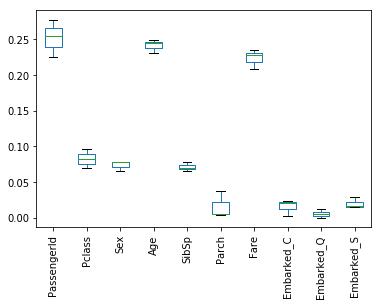

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

df_train = pd.read_csv("train.csv")

# 欠損値を埋める
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train["Cabin"] = df_train["Cabin"].fillna(df_train["Cabin"].mode())
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode())

# train
df_train.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
df_train["Sex"] = df_train["Sex"].replace({"male": 0, "female": 1})
df_train = pd.get_dummies(df_train)

train_y = df_train["Survived"]
train_x = df_train.drop("Survived", axis=1)

clf = xgb.XGBClassifier()
clf.fit(train_x, train_y)

accuracies = []
feature_importances = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for train_idx, test_idx in cv.split(train_x, train_y):
    trn_x = train_x.iloc[train_idx, :]
    val_x = train_x.iloc[test_idx, :]

    trn_y = train_y.iloc[train_idx]
    val_y = train_y.iloc[test_idx]

    clf = xgb.XGBClassifier()
    clf.fit(trn_x, trn_y)

    pred_y = clf.predict(val_x)
    accuracies.append(accuracy_score(val_y, pred_y))
    feature_importances.append(clf.feature_importances_)

print(np.mean(accuracies))

df_fimp = pd.DataFrame(feature_importances, columns=train_x.columns)
df_fimp.plot(kind="box", rot=90)

今回は、pandasのplot機能を使用しました。

pandasのplot機能は見た目はまあまあなものの、簡易に図を得ることができます。

[nkmkさん](https://note.nkmk.me/python-pandas-plot/) のページの解説が詳しいので、実際に必要な場合はこちらを見ながら試行錯誤するとよいでしょう。

そして、PassengerIdが特徴量の上位に入っていることがわかります。

明らかに予測に関係なさそうな変数なので、予測からは取り除きます。（次の章から反映させます）

## 機械学習の精度を上げる

### 機械学習の精度を上げるには

機械学習の精度を上げるにはだいたい3つの手法があります。

 - 特徴量エンジニアリング

 - 機械学習のハイパーパラメータのチューニング

 - アンサンブル
 
この中で、（一般的に）特徴量エンジニアリングが１番大きな効果が出ます。

機械学習のハイパーパラメータチューニングは７章で取り上げます。

アンサンブルについても７章で少し取り上げます。

### 特徴量エンジニアリングとは?

> 機械学習に入れるための特徴量とも呼ばれる追加の予測因子を構築してデータセットに追加すること

https://www.datarobot.com/jp/wiki/feature-engineering/

要するに「学習するデータに新しい説明変数（予測する元となる変数）を足してあげることで、機械学習の精度を上げること」です。

例えば、とある中学校での中間テストの点数と、その子が希望校に合格したかというテーブルがあるとします。

 - ソースコード


In [15]:
df = pd.DataFrame({
    "国語": [80, 20, 30, 40],
    "数学": [20, 30, 40, 20],
    "英語": [40, 20, 30, 10],
    "合格": ["O", "X", "O", "X"]
}, index=["A", "B", "C", "D"])
df

,合格,国語,数学,英語
A,O,80,20,40
B,X,20,30,20
C,O,30,40,30
D,X,40,20,10


３教科の合計点を特徴量に加えてみます。

 - ソースコード

In [16]:
df["合計点"] = df["国語"] + df["数学"] + df["英語"]
df

,合格,国語,数学,英語,合計点
A,O,80,20,40,140
B,X,20,30,20,70
C,O,30,40,30,100
D,X,40,20,10,70


見るからに合計点が高い人が合格していることがわかるかと思います。

このように、**新たな特徴量を追加することで機械学習の精度を上げる** ことを特徴量エンジニアリングといいます。

（なお、不要な特徴量を削除することも特徴量エンジニアリングの一種です。）

## 特徴量エンジニアリングについて

特徴量エンジニアリングは、①仮説を立て、②コードを書き、③機械学習を回して精度が上がるかを確かめるという３ステップを繰り返します。

この中で、①の仮説を立てるためにまずは探索的データ解析（Explanatory Data Analysis; EDA）を行います。

ここでは、主に**seaborn**というpythonのライブラリを用いて可視化をしてみます。

## EDA

 - 数値の分布を見る <br>
     → ヒストグラムを使用
 
 - 特徴量同士の相関を見る <br>
     → ヒートマップ
 
 - カテゴリカルデータで生存に差があるか見る <br>
     → 棒グラフ、箱ひげ図

### 数値の分布を見る

数値の分布を見ることはデータ解析においてとても大事です。

 - データの外れ値により機械学習のアルゴリズムが誤った学習をする
     → 外れ値を除いてから機械学習に使用することで機械学習の精度がUPする

 - データが正規分布に従っていないため、機械学習のアルゴリズムが学習しづらい
     → 対数を取ってから機械学習に使用することで機械学習の精度がUPする

などなどの効能があります。

今回は、Ageの分布を見てみます。

ここではヒストグラムと、ヒストグラムのカーネル密度推定の結果を重ね合わせる `sns.distplot()`を使用します。

#### （復習）ヒストグラムとは?

[このサイト](https://wa3.i-3-i.info/word15620.html)の説明が割とわかりやすいです。

一言で言うと、ある程度の幅で値をまとめてから個数を示す棒グラフのことを指します。

ここでは簡単な例として、テストの点数をヒストグラムで表すことを考えてみます。

とあるクラスの点数が以下のようになっていた場合を考えます。

|点数（数学）|
|-|
|9|
|21|
|24|
|31|
|33|
|35|
|37|
|39|
|42|
|44|
|53|
|62|

これくらいのデータだと30点台が多いことがなんとなくわかると思います。

実際にヒストグラムで表してみます。

 - ソースコード


/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


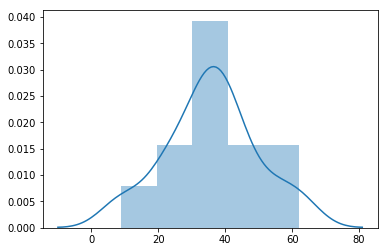

In [17]:
import seaborn as sns

l = [9, 21, 24, 31, 33, 35, 37, 39, 42, 44, 53, 62]

sns.distplot(l)

30点台の人が多いことがわかると思います。

また、ヒストグラムの上にカーネル密度推定の結果も載っています。

カーネル密度推定はヒストグラムを元に作られるなめらかなヒストグラムです。

直感的な説明としては、以下のサイトを参考にするとよいでしょう。

https://www.slideshare.net/KanetakaHeshiki/kde4-mcdonalds

<iframe src="//www.slideshare.net/slideshow/embed_code/key/MclKvohsboom1m?startSlide=23" width="595" height="485" frameborder="0" marginwidth="0" marginheight="0" scrolling="no" style="border:1px solid #CCC; border-width:1px; margin-bottom:5px; max-width: 100%;" allowfullscreen> </iframe> <div style="margin-bottom:5px"> <strong> <a href="//www.slideshare.net/KanetakaHeshiki/kde4-mcdonalds" title="カーネル密度推定を用いた店舗情報の可視化" target="_blank">カーネル密度推定を用いた店舗情報の可視化</a> </strong> from <strong><a href="//www.slideshare.net/KanetakaHeshiki" target="_blank">Kanetaka Heshiki</a></strong> </div>

次に、実際のデータで分布を見てみます。

 - ソースコード


In [4]:
import pandas as pd
import seaborn as sns
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 - ソースコード

/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


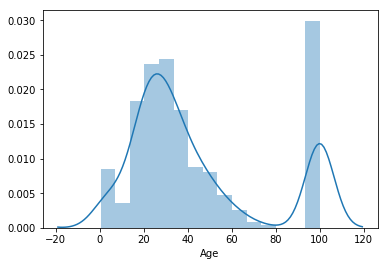

In [5]:
# ここでは、NaNの値がどのくらいあるかも可視化するため、100で埋めています。
sns.distplot(train["Age"].fillna(100))

次に、生存者（Survived == 0）と非生存者（Survived == 1）でヒストグラムを比較してみます。

・0-10は生存者が多い

・NaNは生存者が少ない

ように見えます。

 - ソースコード
 

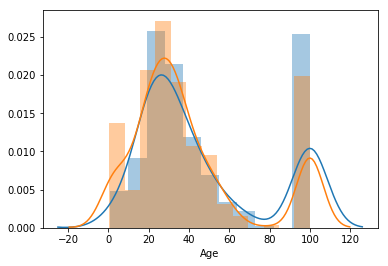

In [6]:
sns.distplot(train.query("Survived == 0")["Age"].fillna(100))
sns.distplot(train.query("Survived == 1")["Age"].fillna(100))

## 特徴量エンジニアリング①：特徴量同士の相関

特徴量同士の相関を見てみます。相関の高い特徴量は片方を取り除いたりすることがあります。

### 相関とは?

相関は「2つ以上の変数があったとき、一方の変数が変化すると、他方もそれに応じて変化する関係」を指します。

先程のデータに追加で理科の点数のデータもあることを考えてみます。

|数学|理科|
|-|-|
|9|12|
|21|15|
|24|31|
|31|21|
|33|42|
|35|21|
|37|35|
|39|43|
|42|54|
|44|51|
|53|43|
|62|70|

 - ソースコード


相関係数 = 0.8679236556726426


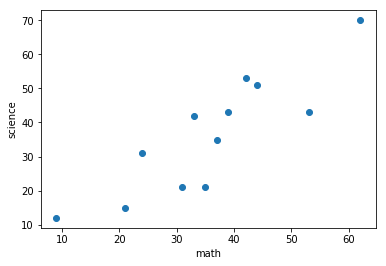

In [22]:
%matplotlib inline
import scipy.stats as st         # 相関係数を計算する用のライブラリ
import matplotlib.pyplot as plt  # 散布図を描くためのライブラリ

scores_math = [9, 21, 24, 31, 33, 35, 37, 39, 42, 44, 53, 62]
scores_science = [12, 15, 31, 21, 42, 21, 35, 43, 53, 51, 43, 70]

print("相関係数 =", st.pearsonr(scores_math, scores_science)[0])
plt.scatter(scores_math, scores_science)
plt.xlabel("math")
plt.ylabel("science")
plt.show()

数学の点数が高いと理科の点数も高い（相関がある）ということがわかると思います。

### 実データで相関を計算（Survivedとの相関）

次に、実データで相関を計算してみます。

pandasの場合、`データフレーム.corr("pearson")` でデータフレーム内の全対全の相関係数を計算してくれます。

全ての相関係数を見るのは大変なので、まずは**目的変数と近いところから見ていくと**よいでしょう。

ということで、Survivedと相関の高い項目を見ていきましょう。

 - ソースコード


In [25]:
# 相関 - Survivedのみ
df_train = pd.read_csv("train.csv")

# 性別は01変換
df_train["Sex"] = df_train["Sex"].replace({"male": 0, "female": 1})

# Embarkedはダミー変数化する
df_train = pd.concat([df_train, pd.get_dummies(train["Embarked"])], axis=1)
df_train.drop(["Embarked"], axis=1, inplace=True)

# Sex, Fareは正の相関が強く、Pclassは負の相関が高い。
# Sexは女性・子どもは優先して助けられたということによると思われる。
# 次に相関が高いのはPclassとFare。お金持ちの方が高いところにいたため、生存率が高いと思われる。
df_train.corr("pearson")["Survived"].to_frame()

,Survived
PassengerId,-0.005007
Survived,1.000000
Pclass,-0.338481
Sex,0.543351
Age,-0.077221
SibSp,-0.035322
Parch,0.081629
Fare,0.257307
C,0.168240
Q,0.003650


### 実データで相関を計算（全対全の相関）

[`sns.clustermap`](https://seaborn.pydata.org/generated/seaborn.clustermap.html) で 全対全の相関を可視化してみます。

今回使用したオプションは以下。

`cmap`:  デフォルトのカラーコードでは分かりづらいため、赤青に変更しています。

`annot`: 実際の相関係数をclustermapの上に乗せています。

 - ソースコード


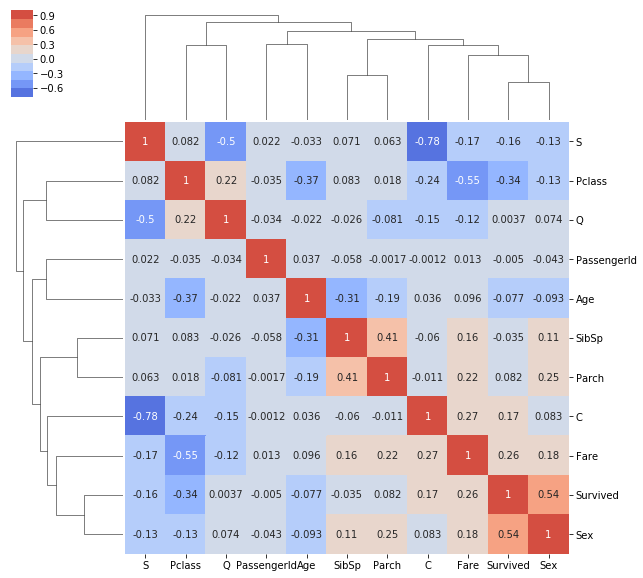

In [26]:
sns.clustermap(df_train.corr("pearson"), annot=True, cmap=sns.color_palette("coolwarm", 10))

SibSpとParchは割と相関が強いことがわかります。

## 特徴量エンジニアリング②：層別解析

先程は全体を俯瞰的に見る解析をしましたが、より詳細に見てみます。

ここでは、**各変数の値で生存する割合が変化するか**を詳細に見てみます。

[`sns.countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html)を使用します。

countplotは基本的にはカウントをしてくれるメソッドなのですが、`x`と`hue`のオプションを使うことで、層別に生存・非生存の数をカウントしてくれます。

なお、`hue`は色相、という意味で、色分けしたい場合（層別にカウントしたい場合）に使われるオプションです。

 - ソースコード


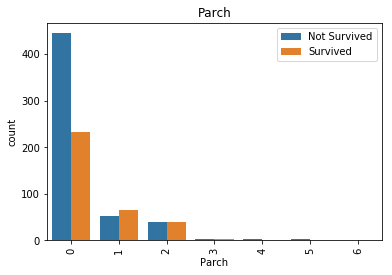

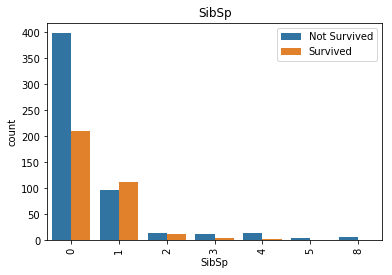

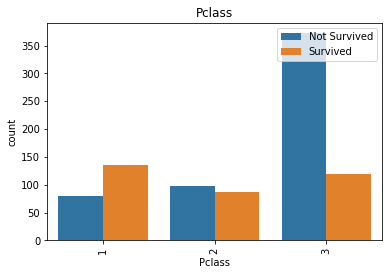

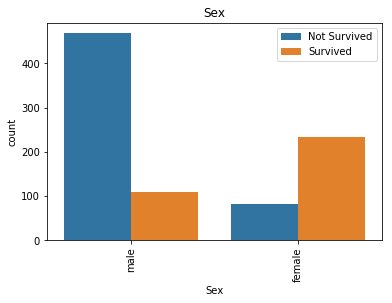

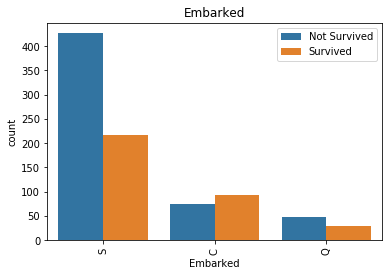

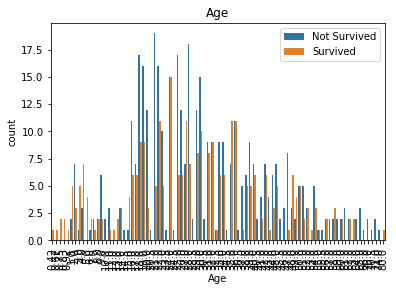

In [27]:
# 置換する値の前の方が解釈しやすいので、もう一度読み直し
df_train = pd.read_csv("train.csv")
for col in ['Parch', 'SibSp', 'Pclass', 'Sex', 'Embarked', 'Age']:
    sns.countplot(x=col, hue='Survived', data=df_train)
    # グラフの微調整
    plt.xticks(rotation=90)
    plt.title(col)
    plt.legend(['Not Survived', 'Survived'], loc='upper right')
    plt.show()

ParchとSibSpは0だとNotSurvived率がすごく高いことがわかります。

総数は多くないものの、ParchとSibSpが多い（4以上）とNotSurvivedが多いこともわかります。

ただ、AgeはこのPlotでは見づらいため、別の手法を考えます。

### catplot

Ageの場合は、**生存した人としなかった人の年齢の分布が知りたい** という問題設定に変えてみます。

[`sns.catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html) を使用します。

 - ソースコード


/Users/yuichiro.nishimoto/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


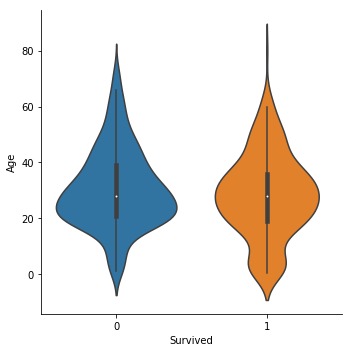

In [29]:
sns.catplot(x="Survived", y="Age", data=df_train, kind='violin')

この図は、[バイオリンプロット](https://www.google.com/search?q=バイオリンプロット)といいます。

カーネル密度推定が横に並べてある感じというとイメージしやすいのではないでしょうか。

[特徴量の可視化](#特徴量の可視化)では重要度が高いものの、

年齢とSurvivedはあまり関係なさそうな印象を受けます。

## おわりに

この章でやったことをまとめると

 - クロスバリデーション

    → 評価用データだけから精度を出すことができた

    
 - 特徴量の重要度
 
    → 判別に効いている特徴量を出すことができた
    
    （真価は次の章で発揮されます）


 - EDA
    
    この章のまとめとしては、以下の3つの仮説が立ちます。
    
    - PassengerIdを除くとよいかも
    
    - Parch, SibSpが0の人はSurvive率が低いかも

    - 0-10は生存者が多いかも

次の章では、この3つの仮説の検証を含めた特徴量エンジニアリングをやってみたいと思います。